/var/folders/39/0c19qs6j0k3gkl1c71w87ghr0000gn/T/ipykernel_103/2622712734.py:36: RuntimeWarning: divide by zero encountered in log10
  ax[1,1].plot(survival, np.log10(np.arange(len(survival))))


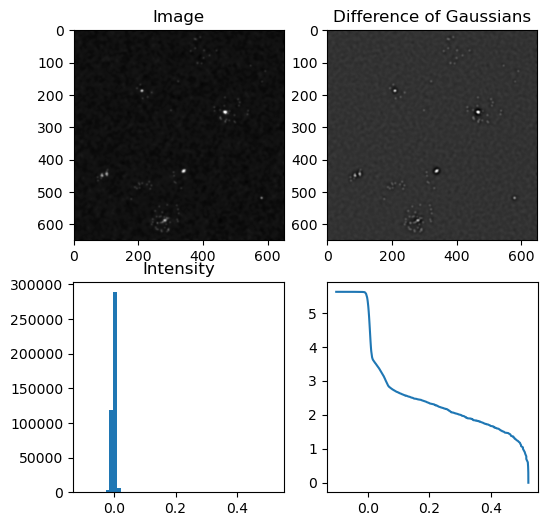

intensity range:  -0.10279021191003723 0.5222816896072586


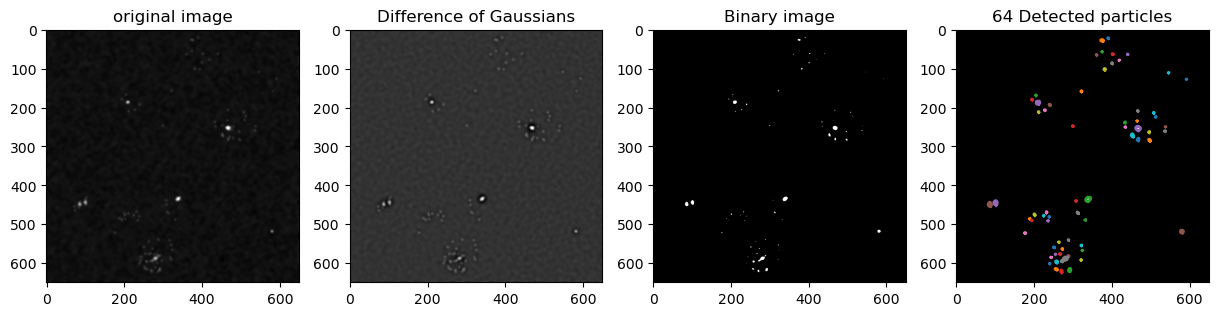

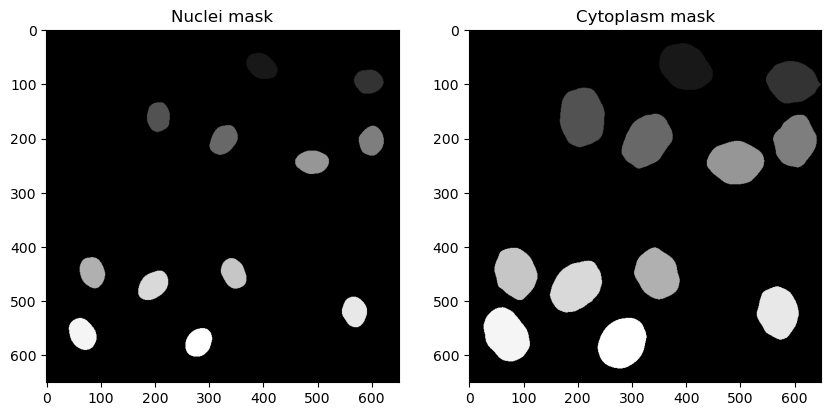

Frame 0:
    Cell ID  mRNA in cytoplasm  mRNA in nucleus
0         1                  7                4
1         2                  1                0
2         3                  6                3
3         4                  1                0
4         5                  0                0
5         6                  8                3
6         7                  3                2
7         8                  2                1
8         9                  6                3
9        10                  1                1
10       11                  0                0
11       12                 15                4
Frame 1:
    Cell ID  mRNA in cytoplasm  mRNA in nucleus
0         1                  4                2
1         2                  2                1
2         3                  7                3
3         4                  1                0
4         5                  2                2
5         6                  7                2
6         7           

In [375]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.filters import difference_of_gaussians
from skimage.measure import label, regionprops
from skimage import measure

# Importing the image as variable img
figName = 'Drug1_1000nM/rep1_FOV1.tif'
img = imread(figName)
type(img)

# Selecting the color channel with RNA spots
zSlice = 0
iChannel = 2
img_spots = img[zSlice,:,:,iChannel]

# Show the original image
fig, ax = plt.subplots(2,2, figsize=(6, 6))
ax[0,0].imshow(img_spots,cmap='Greys_r')
ax[0,0].set(title='Image')

# Apply a difference of Gaussians filter to the image to enhance spots
img_spots_filtered = difference_of_gaussians(img_spots, low_sigma=1, high_sigma=5)
ax[0,1].imshow(img_spots_filtered,cmap='Greys_r')
ax[0,1].set(title= 'Difference of Gaussians' )

# Make a histogram of the intensity values
ax[1,0].hist(img_spots_filtered.flatten(),bins=50)
ax[1,0].set(title= 'Intensity' )

# Make a survival plot of the intensity values
survival = np.sort(img_spots_filtered.flatten())
survival = survival[::-1]
ax[1,1].plot(survival, np.log10(np.arange(len(survival))))

plt.show()
print('intensity range: ', np.min(img_spots_filtered), np.max(img_spots_filtered))

threshold = 0.06

# Show original image in MS2 channel 
fig, ax = plt.subplots(1,4, figsize=(15, 6)) 
ax[0].imshow(img_spots,cmap='Greys_r')
ax[0].set(title='original image')

# Iterate over the frames of the image
for i in range(0, img.shape[0]):
    # Select the current frame's image
    img_spots = img[i,:,:,iChannel]

    # Apply a difference of Gaussians filter to the image to enhance spots
    img_spots_filtered = difference_of_gaussians(img_spots, low_sigma=1, high_sigma=5)
    ax[1].imshow(img_spots_filtered,cmap='Greys_r')
    ax[1].set(title= 'Difference of Gaussians' )

    # Apply a Threshold to the image to create binary image
    img_spots_binary = img_spots_filtered.copy()
    img_spots_binary[img_spots_binary >= threshold] = threshold # Making spots above the threshold equal to the threshold value.
    img_spots_binary[img_spots_binary < threshold] = 0 # Making spots below the threshold equal to 0.
    ax[2].imshow(img_spots_binary,cmap='Greys_r')
    ax[2].set(title= 'Binary image' )

    # Image binarization
    img_spots_binary[img_spots_binary != 0] = 1 # Binarization
    ax[3].imshow(img_spots_binary, cmap=plt.cm.gray)

    # Labeling. Joining pixels in "particles"
    spot_contours = measure.find_contours(img_spots_binary, 0.5)
    for contour in spot_contours:
        ax[3].plot(contour[:, 1], contour[:, 0], linewidth=2)
    ax[3].set(title= str(len(spot_contours)) + ' Detected particles' )
    plt.show()

# Import the masks
figName = 'Drug1_1000nM_masks/rep1_FOV1_mask.tif'
img_masks = imread(figName)

# Separate the channels of the mask tiff
nuc_mask = img_masks[:,:,0]  # nuclei mask
cyto_mask = img_masks[:,:,1]  # cytoplasm mask

# Plot the masks
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(nuc_mask, cmap='Greys_r')
ax[0].set(title='Nuclei mask')
ax[1].imshow(cyto_mask, cmap='Greys_r')
ax[1].set(title='Cytoplasm mask')
plt.show()

# Label each unique cell in the nucleus and cytoplasm masks
labeled_nuc_mask = label(nuc_mask)
labeled_cyto_mask = label(cyto_mask)

# Initialize a DataFrame to hold the counts
df_counts = pd.DataFrame(columns=['Cell ID', 'mRNA in cytoplasm', 'mRNA in nucleus'])

# Iterate over the frames of the image
for i in range(img.shape[0]):
    # Update img_spots for each frame
    img_spots = img[i,:,:,iChannel]
    img_spots_filtered = difference_of_gaussians(img_spots, low_sigma=1, high_sigma=5)
    img_spots_binary = img_spots_filtered.copy()
    img_spots_binary[img_spots_binary >= threshold] = threshold
    img_spots_binary[img_spots_binary < threshold] = 0
    img_spots_binary[img_spots_binary != 0] = 1
    
    # Labeling particles for the current frame
    spot_contours = measure.find_contours(img_spots_binary, 0.5)
    
    # Initialize a list to hold the data for the current frame
    data = []
    # Iterate over each unique cell in the nucleus mask
    for region in regionprops(labeled_nuc_mask):
        cell_id = region.label
        nuc_count = 0
        cyto_count = 0
        
        # Iterate over each mRNA spot
        for spot in spot_contours:
            spot_centroid = np.mean(spot, axis=0)
            y, x = int(spot_centroid[0]), int(spot_centroid[1])
            
            # Check if the spot is inside this nucleus
            if labeled_nuc_mask[y, x] == cell_id:
                nuc_count += 1
            
            # Check if the spot is inside the corresponding cytoplasm
            if labeled_cyto_mask[y, x] == cell_id:
                cyto_count += 1
        
        # Append the counts for the current cell to the list
        data.append({'Cell ID': cell_id, 'mRNA in cytoplasm': cyto_count, 'mRNA in nucleus': nuc_count})
    
    # Create a DataFrame from the list for the current frame
    df_counts_frame = pd.DataFrame(data)
    print(f"Frame {i}:")
    print(df_counts_frame)

    # Concatenate the counts for this frame to the main DataFrame
    df_counts = pd.concat([df_counts, df_counts_frame], ignore_index=True)

# Print the final DataFrame to see all results
print("Final DataFrame:")
print(df_counts)